In [2]:
from blockbaxAnalyser import blockbaxAnalyser
from math import *
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import numpy as np

plt.rcParams.update({'font.size': 26})

coefs = [-0.00012342, 0.00025987, 0.00140314, 0.00271261, -0.02838881, 0.00763725]

test_start_datetime = "2023-03-20 13:00:00"
test_end_datetime = "2023-03-27 13:00:00"

analyser = blockbaxAnalyser(sb_numbers = [163076], 
plot_from_date=test_start_datetime, 
plot_till_date=test_end_datetime)

In [3]:
analyser.loadData()
analyser.dfs[0].drop('Datetime', axis=1, inplace=True)
analyser.dfs[0].drop('Battery', axis=1, inplace=True)
#print(model.dfs[0].to_string())

In [4]:
analyser.dfs[0]["Pred error"] = coefs[0]*analyser.dfs[0]["Temperature"]**2 + \
    coefs[1]*analyser.dfs[0]["Temperature"]*analyser.dfs[0]["Y value"] + \
    coefs[2]*analyser.dfs[0]["Y value"]**2 + \
    coefs[3]*analyser.dfs[0]["Temperature"] + \
    coefs[4]*analyser.dfs[0]["Y value"] + \
    coefs[5]
analyser.dfs[0]["Pred value"] = analyser.dfs[0]["Y value"]+analyser.dfs[0]["Pred error"]
#print(analyser.dfs[0].to_string())


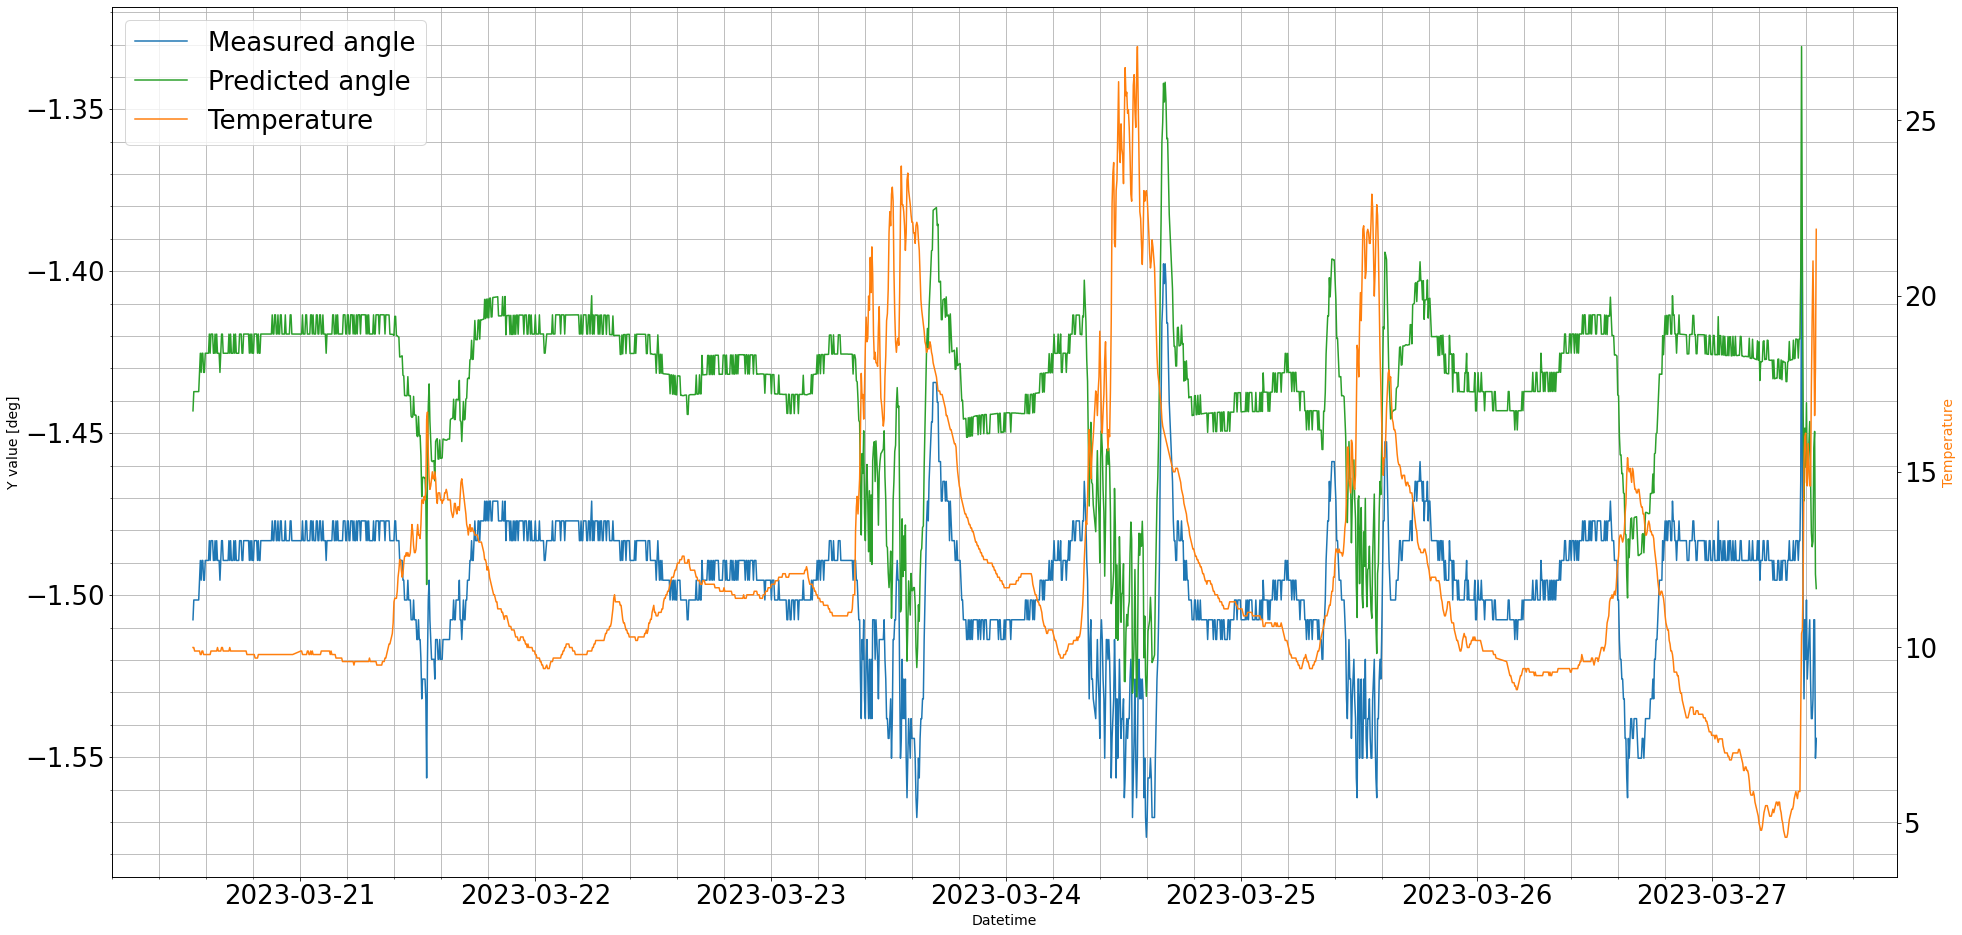

Signal cross-correlations:
Predicted value and temperature:  -34063.37971305847
Min/max/dif of predicted values:  -1.5313681364059448 -1.3306400775909424 0.20072805881500244
Measured value and temperature:  -35488.18784856796
Min/max/dif of measured values:  -1.57470703125 -1.3916015625 0.18310546875


In [5]:
### Plot the data
fig,ax = plt.subplots(figsize=(32,16))
fig.set_facecolor('w')
ln1 = ax.plot(analyser.dfs[0].index,
        analyser.dfs[0]['Y value'],
        color="tab:blue", label = "Measured angle")
ln2 = ax.plot(analyser.dfs[0].index,
        analyser.dfs[0]['Pred value'],
        color='tab:green', label = "Predicted angle")
ax.set_xlabel("Datetime", fontsize = 14)
ax.set_ylabel("Y value [deg]",
        fontsize=14)
ax.minorticks_on()
ax.grid(which='both', axis='both')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ln3 = ax2.plot(analyser.dfs[0].index,
        analyser.dfs[0]["Temperature"],
        color="tab:orange", label = "Temperature")
ax2.set_ylabel("Temperature",color="tab:orange",fontsize=14)

# added these three lines
lns = ln1+ln2+ln3
labs = [ln.get_label() for ln in lns]
ax.legend(lns, labs, loc=0)

plt.show()
# save the plot as a file
fig.savefig('figures\\model_corrected_output.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

C_pt = sum(analyser.dfs[0]["Pred value"]*analyser.dfs[0]["Temperature"])
C_yt = sum(analyser.dfs[0]["Y value"]*analyser.dfs[0]["Temperature"])

print("Signal cross-correlations:")
print("Predicted value and temperature: ", C_pt)
print("Min/max/dif of predicted values: ", min(analyser.dfs[0]["Pred value"]), max(analyser.dfs[0]["Pred value"]),abs(min(analyser.dfs[0]["Pred value"])-max(analyser.dfs[0]["Pred value"])))
print("Measured value and temperature: ", C_yt)
print("Min/max/dif of measured values: ", min(analyser.dfs[0]["Y value"]), max(analyser.dfs[0]["Y value"]),abs(min(analyser.dfs[0]["Y value"])-max(analyser.dfs[0]["Y value"])))


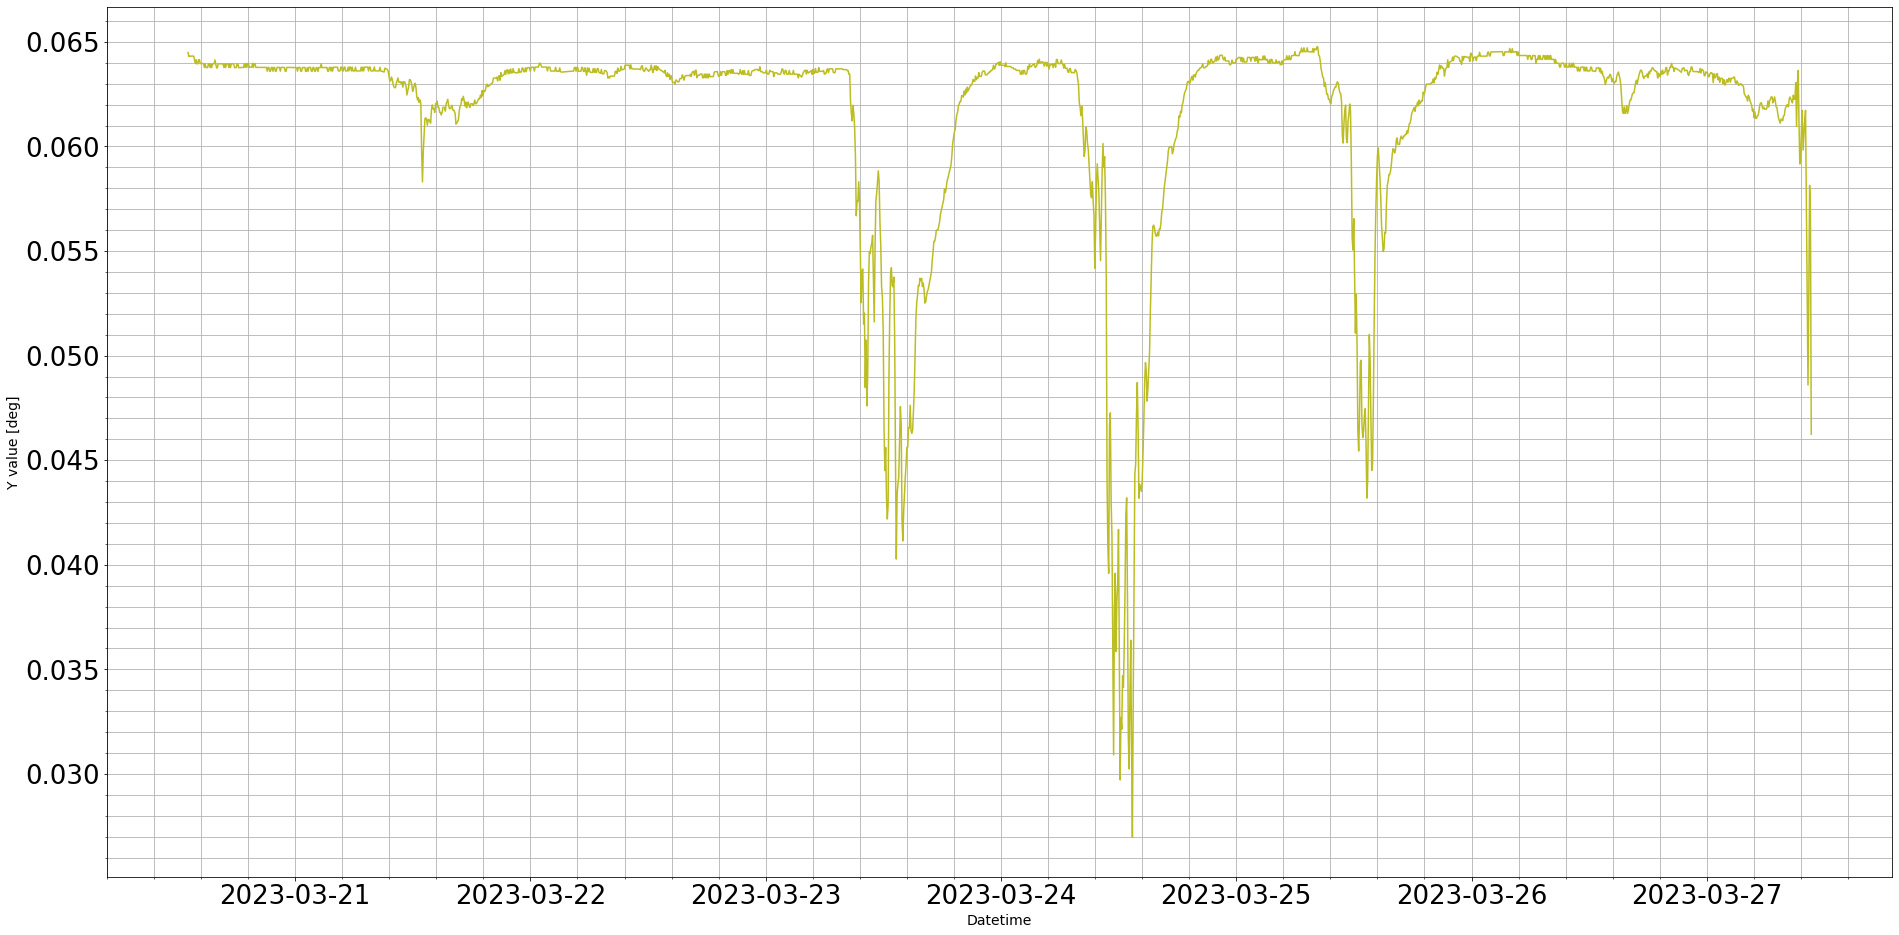

In [6]:
# Plotting the error
fig,ax = plt.subplots(figsize=(32,16))
fig.set_facecolor('w')
ln1 = ax.plot(analyser.dfs[0].index,
        analyser.dfs[0]['Pred error'],
        color="tab:olive", label = "Measured angle")
ax.set_xlabel("Datetime", fontsize = 14)
ax.set_ylabel("Y value [deg]",
        fontsize=14)
ax.minorticks_on()
ax.grid(which='both', axis='both')
# save the plot as a file
fig.savefig('figures\\model_errorterm.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


This does not look like a significant improvement. The green line indicates the predicted 'real' values, and it can be seen that they are not less erratic than the original data (blue). Quantitatively there is a very slight improvement.
Next, we investigate the behaviour with temperature by multiplication and subtraction of the standard transformed data.

### Multiplying standard transformed Y and temperature
The idea below is that we can multiply the Y and temperature signals since they show a negative correlation. The predictability of the change in inclination is then indicated by how close the resulting value stays to zero. We need to standard transform the data to negate any effects relating to the different scaling of the data.
The rationale is like this: When the temperature drops a certain amount, we expect the measured y value to go up a proportional amount. When this happens, the multiple of the standard transformed data stays close to 0. When this doesn't happen, the multiple drops or rises.
When the multiple drops below zero, this indicates that one (but not both!) of the quantities lie below the average. When the multiple risis above zero, both or neither of the quanities 

Cross correlation of stdtf signals
Predicted value - temperature:  -1324.1853975346312
Original value - temperature:  -1093.2101090458455
Standard deviation of original/predicted signal:  0.021052344 0.024000712


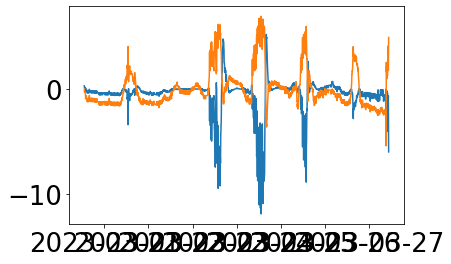

In [7]:
temp_mean = analyser.dfs[0]["Temperature"].mean()
temp_std = analyser.dfs[0]["Temperature"].std()
y_mean = analyser.dfs[0]["Y value"].mean()
y_std = analyser.dfs[0]["Y value"].std()
pred_mean = analyser.dfs[0]["Pred value"].mean()
pred_std = analyser.dfs[0]["Pred value"].std()

analyser.dfs[0]["Y stdtf"] = (analyser.dfs[0]["Y value"]-y_mean)/y_std
analyser.dfs[0]["Temp stdtf"] = (analyser.dfs[0]["Temperature"]-temp_mean)/temp_std
analyser.dfs[0]["Pred stdtf"] = (analyser.dfs[0]["Pred value"]-pred_mean)/pred_std

analyser.dfs[0]["Multiplied"] = analyser.dfs[0]["Y stdtf"]*analyser.dfs[0]["Temp stdtf"]
analyser.dfs[0]["Subtracted"] = analyser.dfs[0]["Temp stdtf"]-analyser.dfs[0]["Y stdtf"]

print("Cross correlation of stdtf signals")
print("Predicted value - temperature: ", sum(analyser.dfs[0]["Pred stdtf"]*analyser.dfs[0]["Temp stdtf"]))
print("Original value - temperature: ",sum(analyser.dfs[0]["Y stdtf"]*analyser.dfs[0]["Temp stdtf"]))
print("Standard deviation of original/predicted signal: ", y_std, pred_std)
plt.plot(analyser.dfs[0]["Multiplied"])
plt.plot(analyser.dfs[0]["Subtracted"])

## Next steps
Afteer discussing the intermediate results, we have identified a path forward. The steps consist of:
1. Splitting the data to omit the peaks, showing both good performance (next to peaks) and bad performance (at the peaks).
2. Make model of treatment test and generate results.
3. Make temperature-only model (such as e.g. Fredericks model) and apply.

### 1. Split data
Shown below.

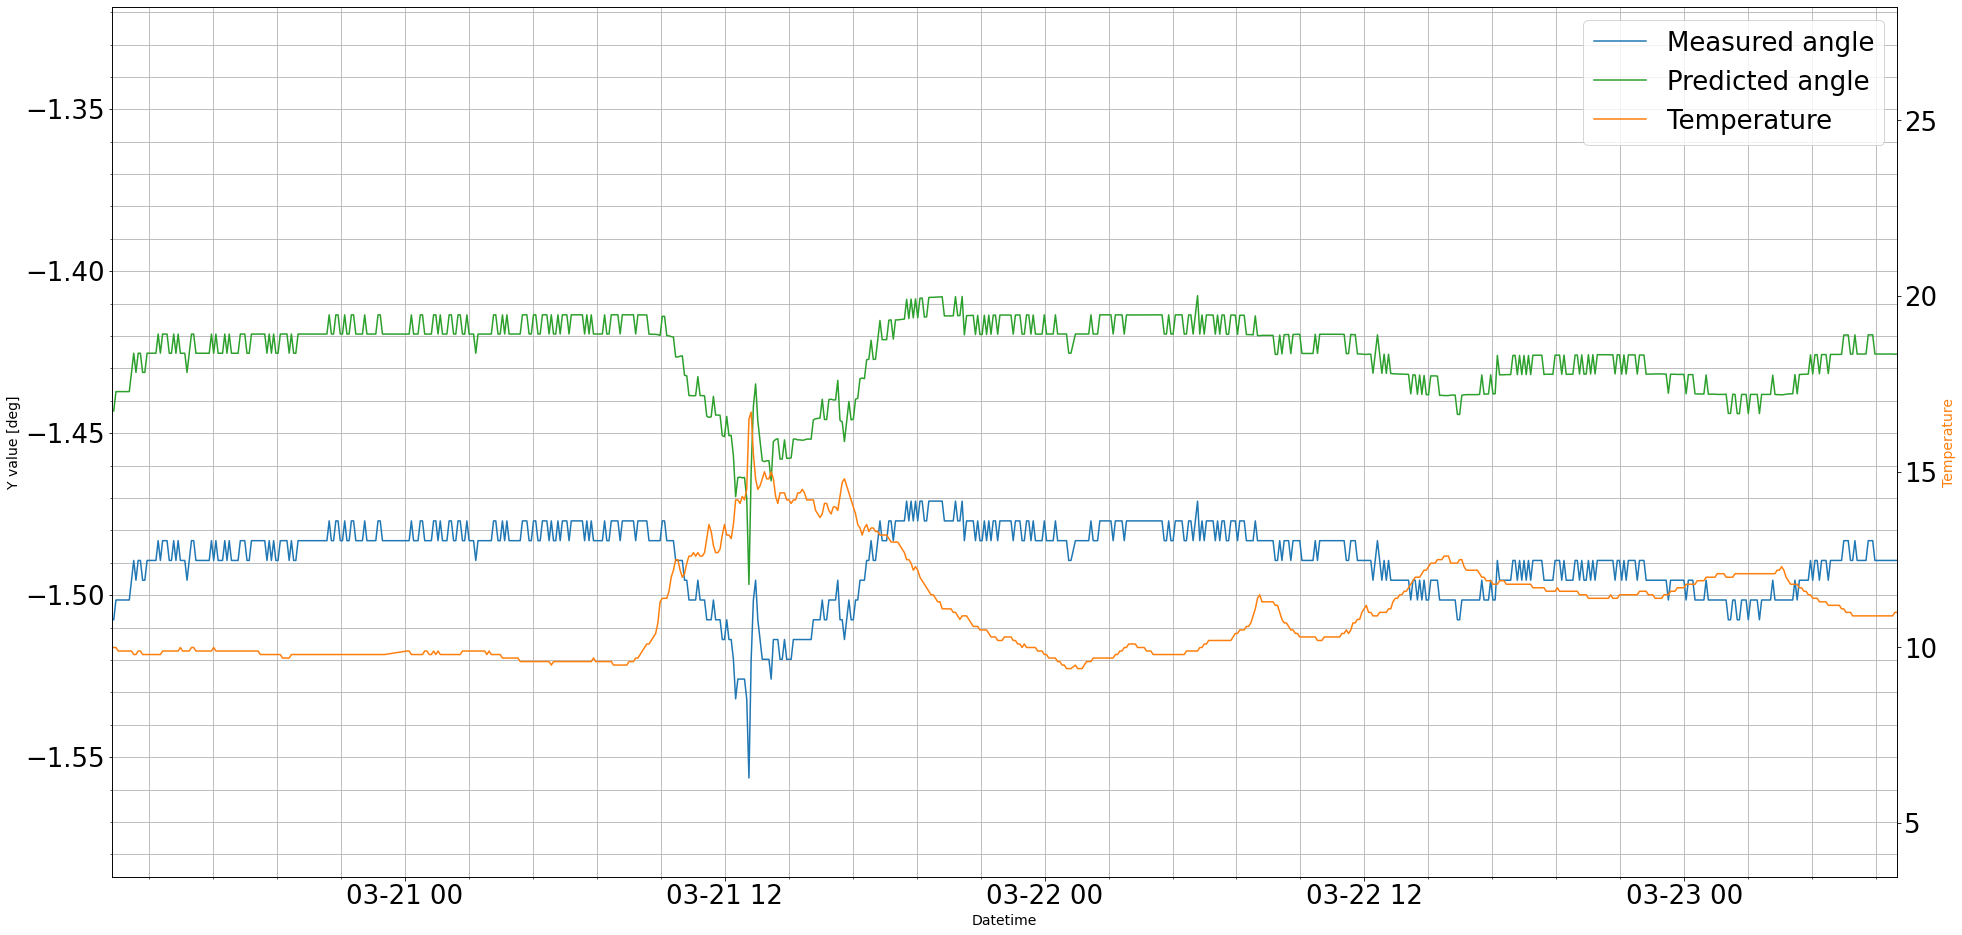

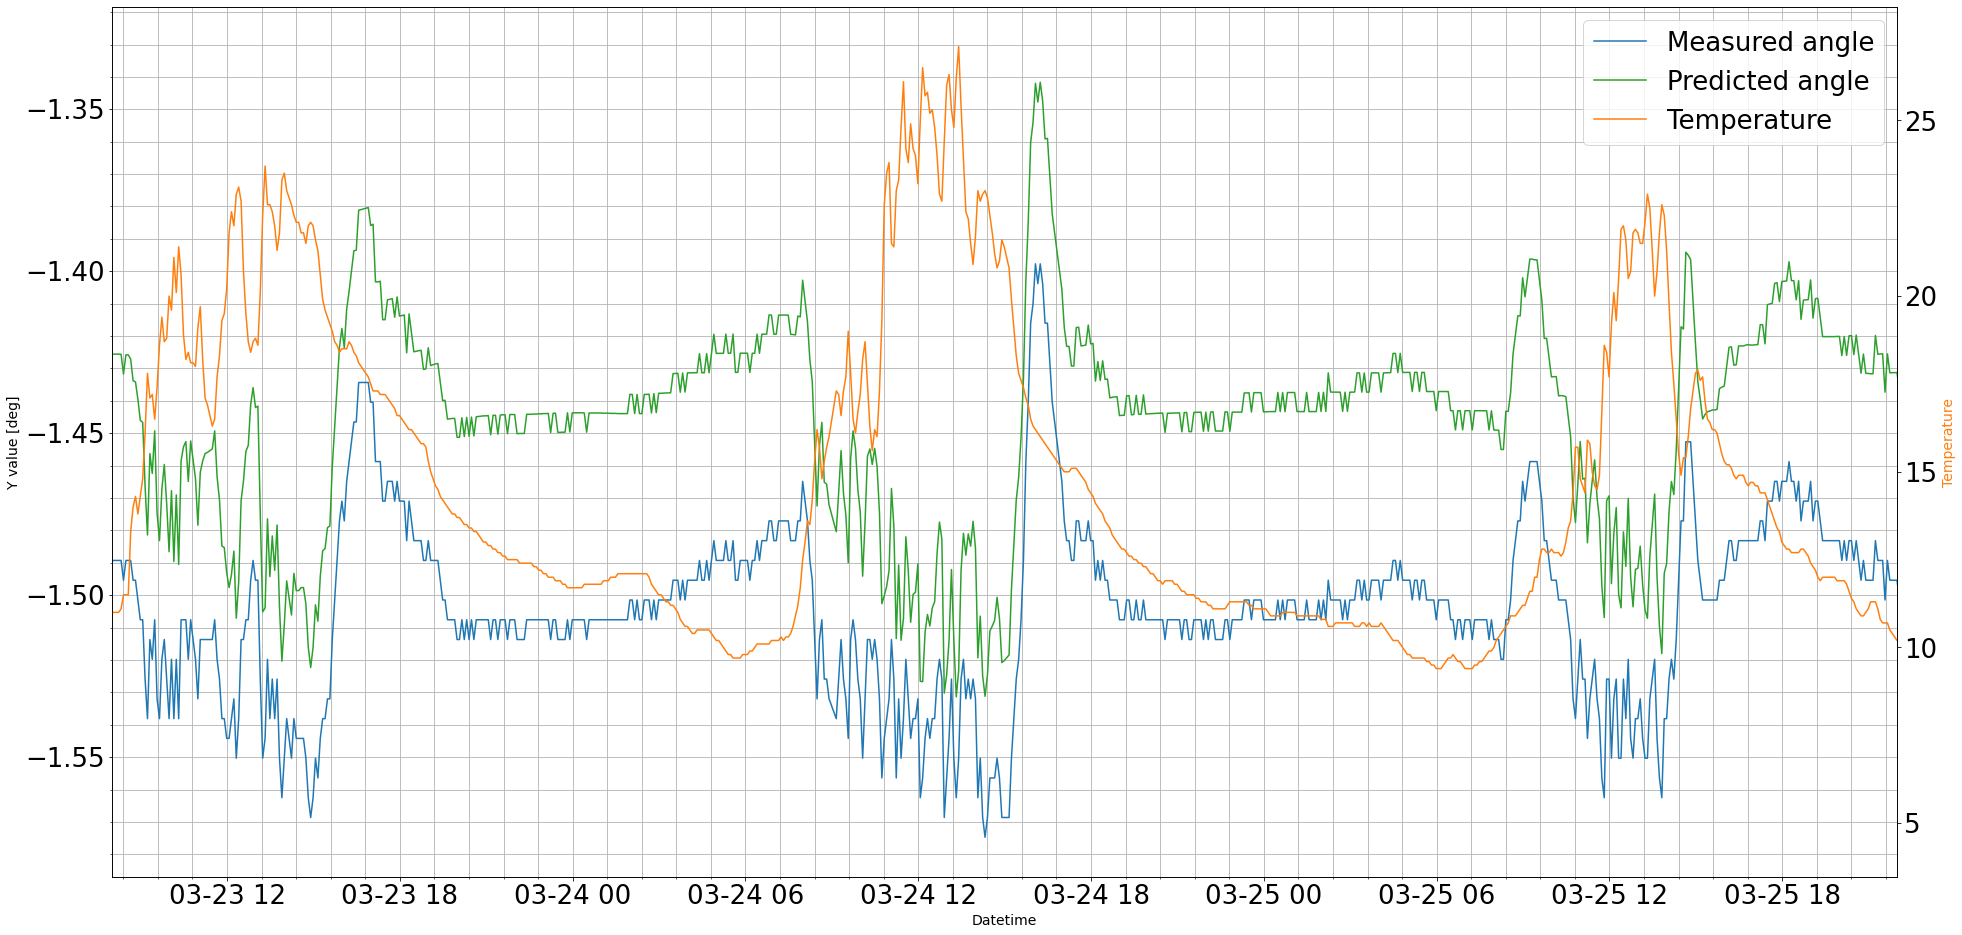

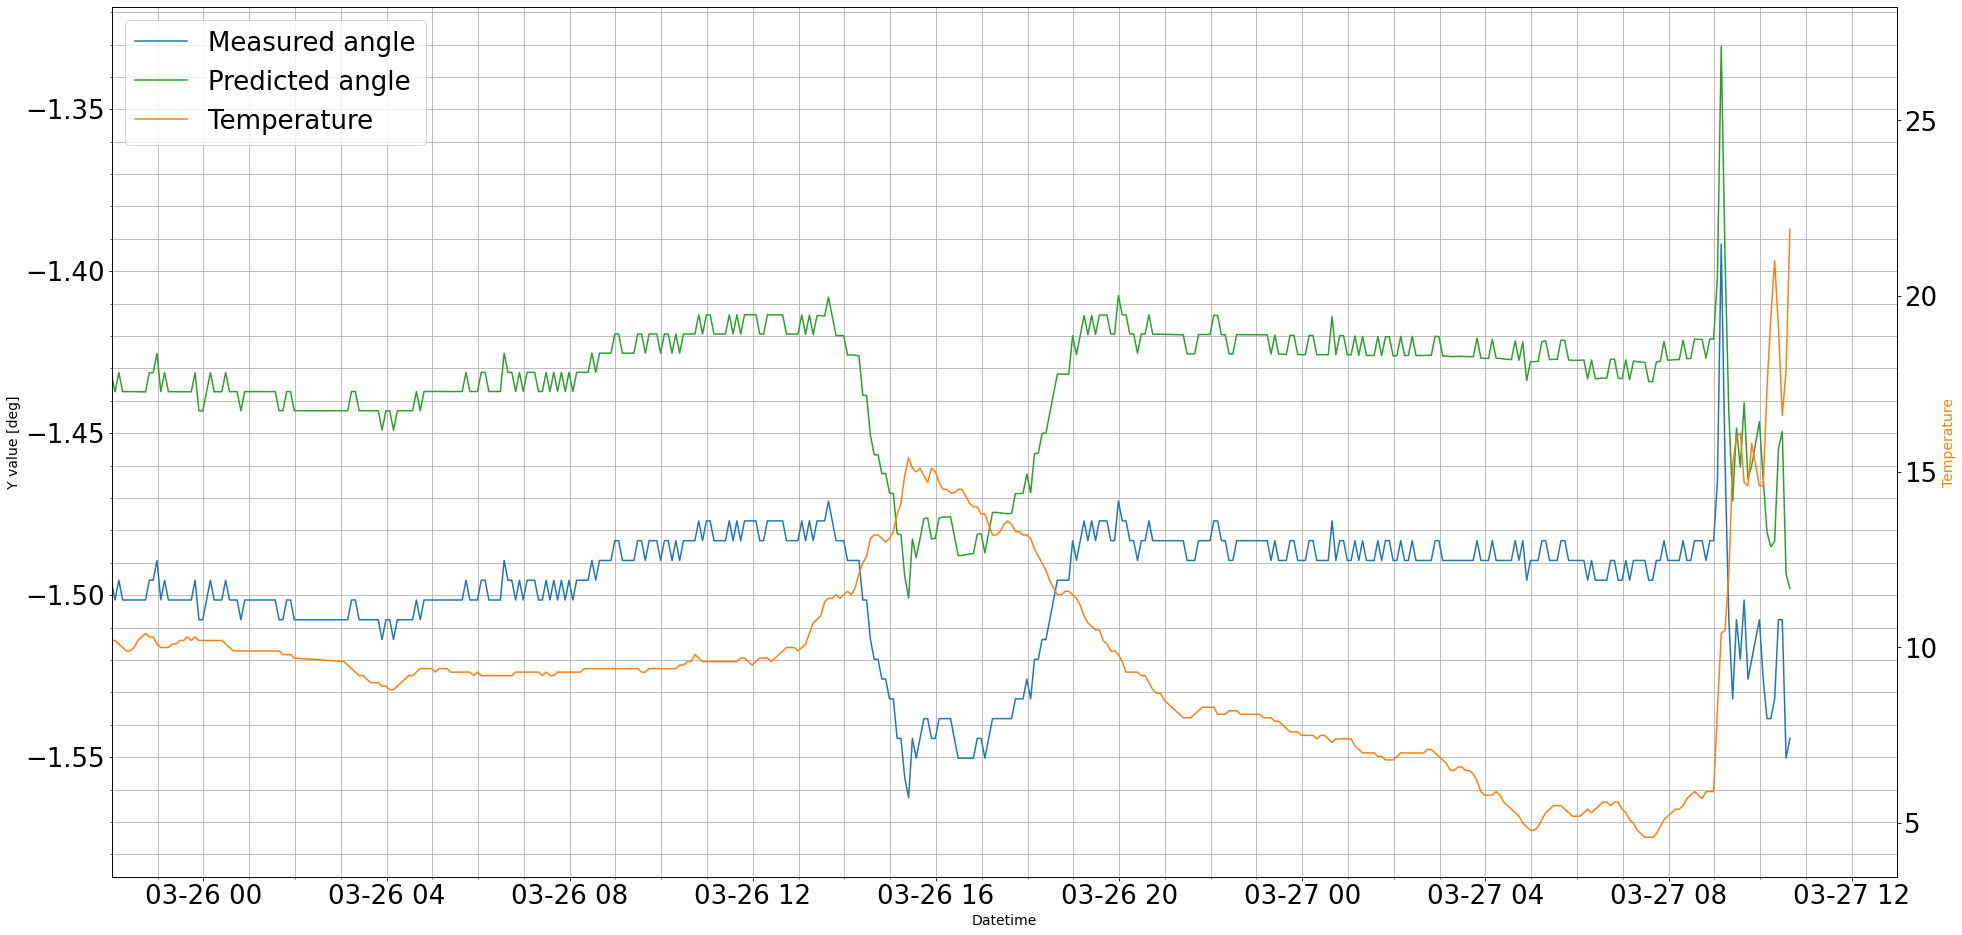

In [8]:
interval1_start = datetime.strptime("2023-03-20 13:00:00", "%Y-%m-%d %H:%M:%S")
interval1_end = datetime.strptime("2023-03-23 08:00:00", "%Y-%m-%d %H:%M:%S")
interval2_start = interval1_end
interval2_end = datetime.strptime("2023-03-25 22:00:00", "%Y-%m-%d %H:%M:%S")
interval3_start = interval2_end
interval3_end = datetime.strptime("2023-03-27 13:00:00", "%Y-%m-%d %H:%M:%S")

def makePlot(start,end):
        ### Plot the data
        fig,ax = plt.subplots(figsize=(32,16))
        fig.set_facecolor('w')
        ln1 = ax.plot(analyser.dfs[0].index,
                analyser.dfs[0]['Y value'],
                color="tab:blue", label = "Measured angle")
        ln2 = ax.plot(analyser.dfs[0].index,
                analyser.dfs[0]['Pred value'],
                color='tab:green', label = "Predicted angle")
        ax.set_xlim(start,end)
        ax.set_xlabel("Datetime", fontsize = 14)
        ax.set_ylabel("Y value [deg]",
                fontsize=14)
        ax.minorticks_on()
        ax.grid(which='both', axis='both')

        # twin object for two different y-axis on the sample plot
        ax2=ax.twinx()
        # make a plot with different y-axis using second axis object
        ln3 = ax2.plot(analyser.dfs[0].index,
                analyser.dfs[0]["Temperature"],
                color="tab:orange", label = "Temperature")
        ax2.set_ylabel("Temperature",color="tab:orange",fontsize=14)

        # added these three lines
        lns = ln1+ln2+ln3
        labs = [ln.get_label() for ln in lns]
        ax.legend(lns, labs, loc=0)

        plt.show()

makePlot(interval1_start,interval1_end)
makePlot(interval2_start,interval2_end)
makePlot(interval3_start,interval3_end)

### 2. Make model of treatment test and retest
Below is the code for making the model. Take note that this model also includes the effect of the styrofoam.


Polynomial fit, inputs and references NOT standard transformed
Feature names:  ['1' 'x0' 'x1' 'x0^2' 'x0 x1' 'x1^2']
Model coefficients:  [-3.27713166e-02 -2.62730969e-02  1.49085211e-03  1.05299181e-03
  3.17754867e-04 -3.57154189e-05]
x1 = temp, x0 = meas angle


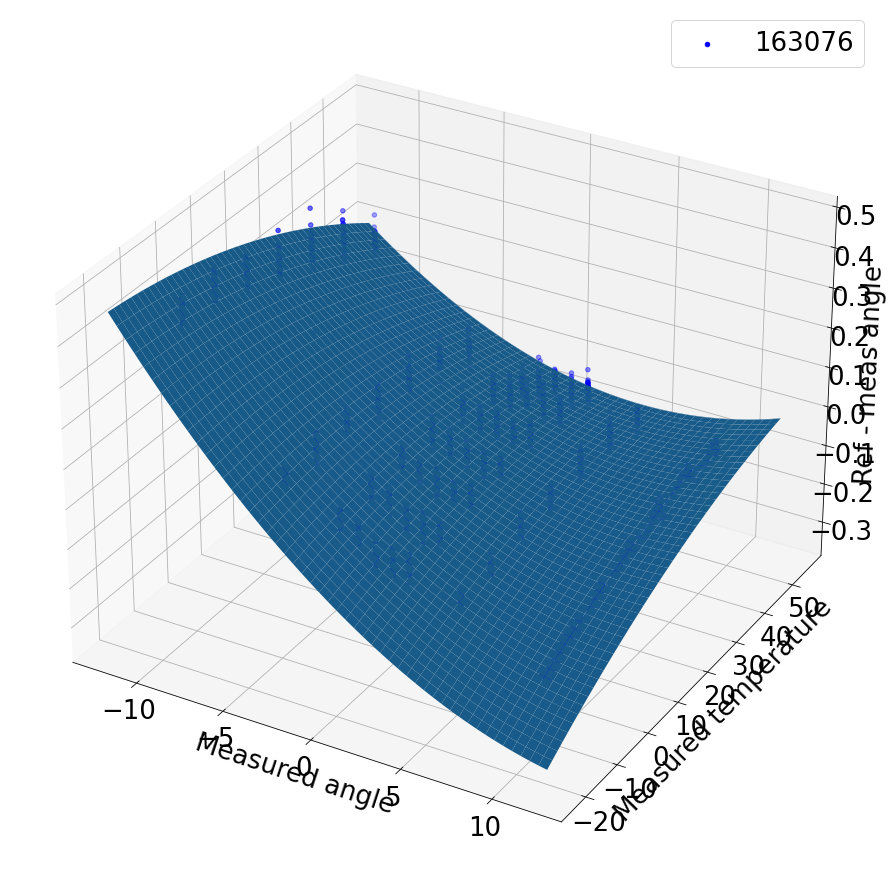

<Figure size 432x288 with 0 Axes>

In [9]:
# Determining the model coefficients
# Reload data
test_start_datetime = "2023-02-20 18:00:00"
test_end_datetime = "2023-02-28 21:00:00"

offset_date_start = "2023-02-24 18:30:00" 
offset_date_end = "2023-02-24 21:30:00"

model = blockbaxAnalyser(sb_numbers = [163076], 
plot_from_date=test_start_datetime, 
plot_till_date=test_end_datetime)

model.loadData()
model.loadRefData(filename = os.path.join(os.path.abspath('').removesuffix('blockbaxAnalyser.py'),"Ref","jewell_ref_treatment.txt"))
model.determineOffsets(offset_date_start,offset_date_end)
model.matchRefData()
i = 0

reflist = []
print("Polynomial fit, inputs and references NOT standard transformed") 

poly = PolynomialFeatures(degree = model.poly_degree)       
ylist = model.dfs[i]['Y value'].tolist()
templist = model.dfs[i]['Temperature'].tolist()

#reflist = analyser.dfs[i]['Reference'].tolist() # Predicts reference
reflist = (model.dfs[i]['Reference']-model.dfs[i]['Y value']).tolist() # Predicts error

indep_vars = np.transpose(np.array([ylist, templist]))
dep_vars = np.array(reflist)

indep_vars_ = poly.fit_transform(indep_vars)
print("Feature names: ", poly.get_feature_names_out())
model.feature_names = poly.get_feature_names_out()

# Create regression object and perform regression
model.model = linear_model.LinearRegression(fit_intercept=True)
model.model.fit(indep_vars_, dep_vars)
model.model.coef_[0] = model.model.intercept_
print("Model coefficients: ", model.model.coef_)
print("x1 = temp, x0 = meas angle")

# Plot the model
fig = plt.figure(figsize=(32,16))
ax = fig.add_subplot(projection='3d')

# FIRST: Plot surface from model
x0_mesh = np.arange(-12, 12, 0.01) # Measured angle mesh
x1_mesh = np.arange(-22, 55, 0.1) # Measured temperature mesh
x0_mesh, x1_mesh = np.meshgrid(x0_mesh, x1_mesh)

y_mesh = model.model.coef_[0]*1 + model.model.coef_[1]*x0_mesh + model.model.coef_[2]*x1_mesh + model.model.coef_[3]*x0_mesh*x0_mesh + model.model.coef_[4]*x0_mesh*x1_mesh + model.model.coef_[5]*x1_mesh*x1_mesh

ax.plot_surface(x0_mesh, x1_mesh, y_mesh) # find out transparant surface map

# SECOND: Plot scattered data
ax.scatter(model.dfs[i]['Y value'], model.dfs[i]['Temperature'], model.dfs[i]['Reference']-model.dfs[i]['Y value'], color=model.colours[i], label=model.sb_numbers[i])

# Cleanup
ax.set_xlabel("Measured angle")
ax.set_ylabel("Measured temperature")
ax.set_zlabel("Ref - meas angle")
ax.legend()
plt.show()
if True:
    plt.savefig('Figures\\Model'+str(163076)+'.png',dpi='figure')

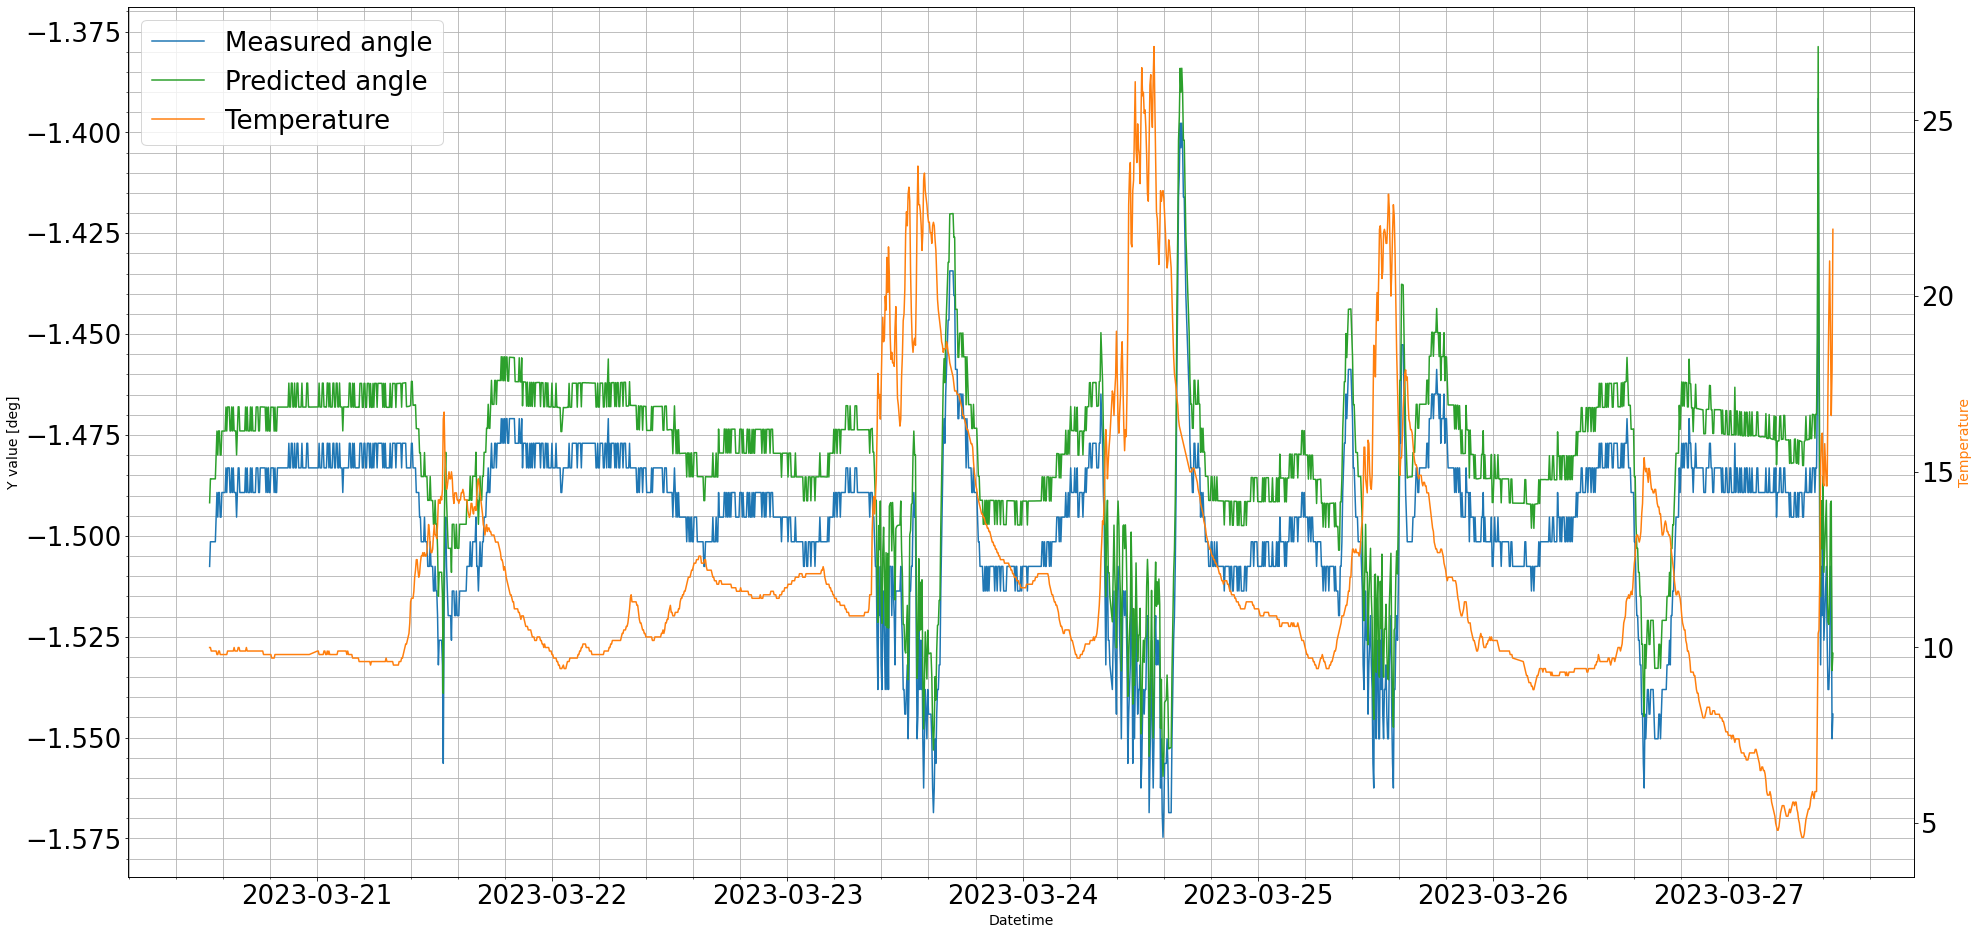

Signal cross-correlations:
Predicted value and temperature:  -35121.743175029755
Min/max/dif of predicted values:  -1.5596071481704712 -1.3787288665771484 0.18087828159332275
Measured value and temperature:  -35488.18784856796
Min/max/dif of measured values:  -1.57470703125 -1.3916015625 0.18310546875


In [10]:
coefs2 = [-3.57154189e-05, 3.17754867e-04, 1.05299181e-03, 1.49085211e-03, -2.62730969e-02, -3.27713166e-02]

analyser.dfs[0]["Pred 2 error"] = coefs2[0]*analyser.dfs[0]["Temperature"]**2 + \
    coefs2[1]*analyser.dfs[0]["Temperature"]*analyser.dfs[0]["Y value"] + \
    coefs2[2]*analyser.dfs[0]["Y value"]**2 + \
    coefs2[3]*analyser.dfs[0]["Temperature"] + \
    coefs2[4]*analyser.dfs[0]["Y value"] + \
    coefs2[5]
analyser.dfs[0]["Pred 2 value"] = analyser.dfs[0]["Y value"]+analyser.dfs[0]["Pred 2 error"]

### Plot the data
fig,ax = plt.subplots(figsize=(32,16))
fig.set_facecolor('w')
ln1 = ax.plot(analyser.dfs[0].index,
        analyser.dfs[0]['Y value'],
        color="tab:blue", label = "Measured angle")
ln2 = ax.plot(analyser.dfs[0].index,
        analyser.dfs[0]['Pred 2 value'],
        color='tab:green', label = "Predicted angle")
ax.set_xlabel("Datetime", fontsize = 14)
ax.set_ylabel("Y value [deg]",
        fontsize=14)
ax.minorticks_on()
ax.grid(which='both', axis='both')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ln3 = ax2.plot(analyser.dfs[0].index,
        analyser.dfs[0]["Temperature"],
        color="tab:orange", label = "Temperature")
ax2.set_ylabel("Temperature",color="tab:orange",fontsize=14)

# added these three lines
lns = ln1+ln2+ln3
labs = [ln.get_label() for ln in lns]
ax.legend(lns, labs, loc=0)

plt.show()
# save the plot as a file
fig.savefig('figures\\model_corrected_output_treatment.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

C_pt = sum(analyser.dfs[0]["Pred 2 value"]*analyser.dfs[0]["Temperature"])
C_yt = sum(analyser.dfs[0]["Y value"]*analyser.dfs[0]["Temperature"])

print("Signal cross-correlations:")
print("Predicted value and temperature: ", C_pt)
print("Min/max/dif of predicted values: ", min(analyser.dfs[0]["Pred 2 value"]), max(analyser.dfs[0]["Pred 2 value"]),abs(min(analyser.dfs[0]["Pred 2 value"])-max(analyser.dfs[0]["Pred 2 value"])))
print("Measured value and temperature: ", C_yt)
print("Min/max/dif of measured values: ", min(analyser.dfs[0]["Y value"]), max(analyser.dfs[0]["Y value"]),abs(min(analyser.dfs[0]["Y value"])-max(analyser.dfs[0]["Y value"])))


We can see that the coefficients of the new model are much smaller, both for the angle and the temperature terms. As such, the predicted signal is also very similar to the original signal because the calculated errors are small. The model improves the situation somewhat but it's almost not noticable.

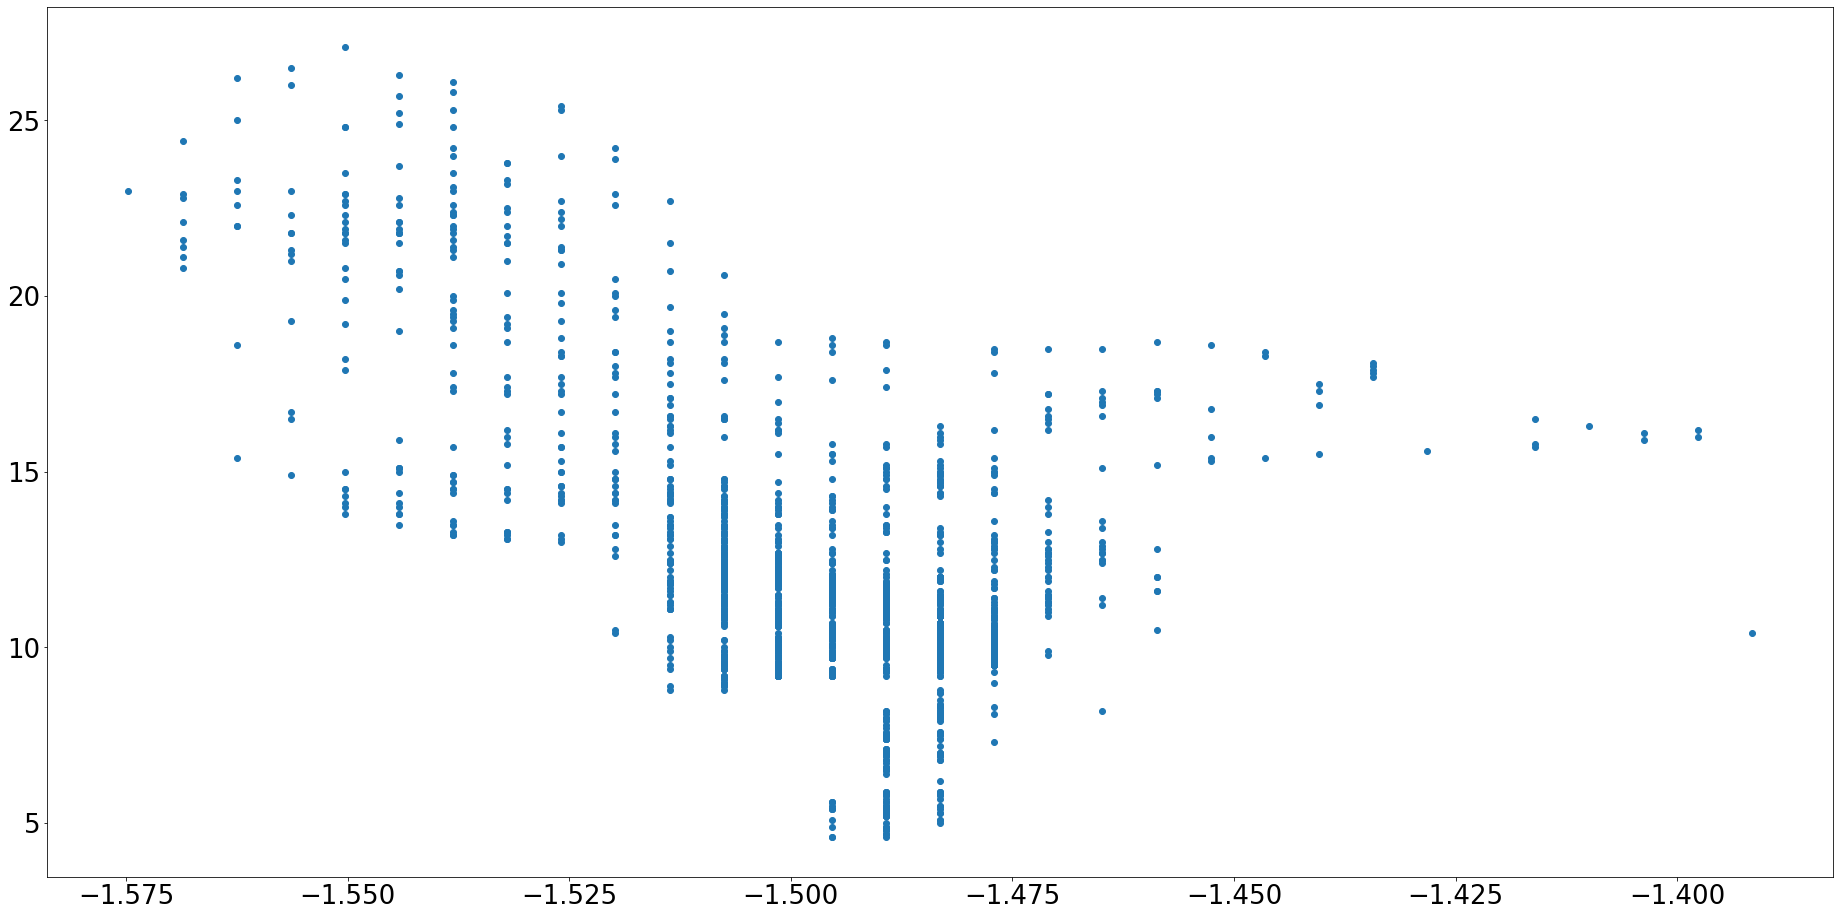

In [11]:
fig,ax = plt.subplots(figsize=(32,16))
fig.set_facecolor('w')
ax.scatter(analyser.dfs[0]["Y value"],analyser.dfs[0]['Temperature'])
plt.show()

### 3. Temperature-only model
- Idea: To fit a model (we first try a second degree polynomial) to map the temperature to the error from the data of the initial test.
- First plot the error against temperature
- Then create model (or several models of differing polynomial degrees)
- Plot models to check fit
- Create and check model of treatment test as well

In [13]:
## Temperature-only model
# Idea: To fit a model (we first try a second degree polynomial) to map the temperature to the error from the data of the initial test.
# First plot the error against temperature
# Then create model (or several models of differing polynomial degrees)
# Plot models to check fit
# Create and check model of treatment test as well

test_start_datetime = "2023-01-19 18:30:00"
test_end_datetime = "2023-01-29 22:00:00"

offset_date_start = "2023-01-25 05:30:00"
offset_date_end = "2023-01-25 07:30:00"

analyser = blockbaxAnalyser(sb_numbers = [163076], 
plot_from_date=test_start_datetime, 
plot_till_date=test_end_datetime)
analyser.loadData()
analyser.loadRefData(filename = os.path.join(os.path.abspath('').removesuffix('blockbaxAnalyser.py'),"Ref","jewell_ref_control.txt"))
analyser.determineOffsets(offset_date_start,offset_date_end)
analyser.matchRefData()
analyser.dfs[0].drop('Datetime', axis=1, inplace=True)
analyser.dfs[0].drop('Battery', axis=1, inplace=True)

analyser.dfs[0]["Error"] = analyser.dfs[0]["Reference"] - analyser.dfs[0]["Y value"]

print(analyser.dfs[0].to_string())

                     Temperature    Y value  Reference  Reference temp     Error
Datetime                                                                        
2023-01-19 18:32:18   -15.400000  10.206604   9.955527         -16.772 -0.251077
2023-01-19 18:37:27   -16.100000  10.212708   9.936427         -17.301 -0.276281
2023-01-19 18:42:20   -16.400000  10.212708   9.935127         -17.508 -0.277581
2023-01-19 18:47:35   -16.799999  10.212708   9.955527         -17.690 -0.257181
2023-01-19 18:52:44   -17.000000  10.218811   9.948427         -17.763 -0.270384
2023-01-19 18:57:27   -16.799999  10.212708   9.956427         -17.790 -0.256281
2023-01-19 19:02:47   -17.200001  10.200500   9.928827         -17.868 -0.271674
2023-01-19 19:07:34   -17.000000  10.212708   9.928827         -17.865 -0.283881
2023-01-19 19:12:44   -17.299999  10.212708   9.954527         -17.895 -0.258181
2023-01-19 19:17:49   -17.100000  10.194397   9.945827         -17.907 -0.248570
2023-01-19 19:22:31   -17.10

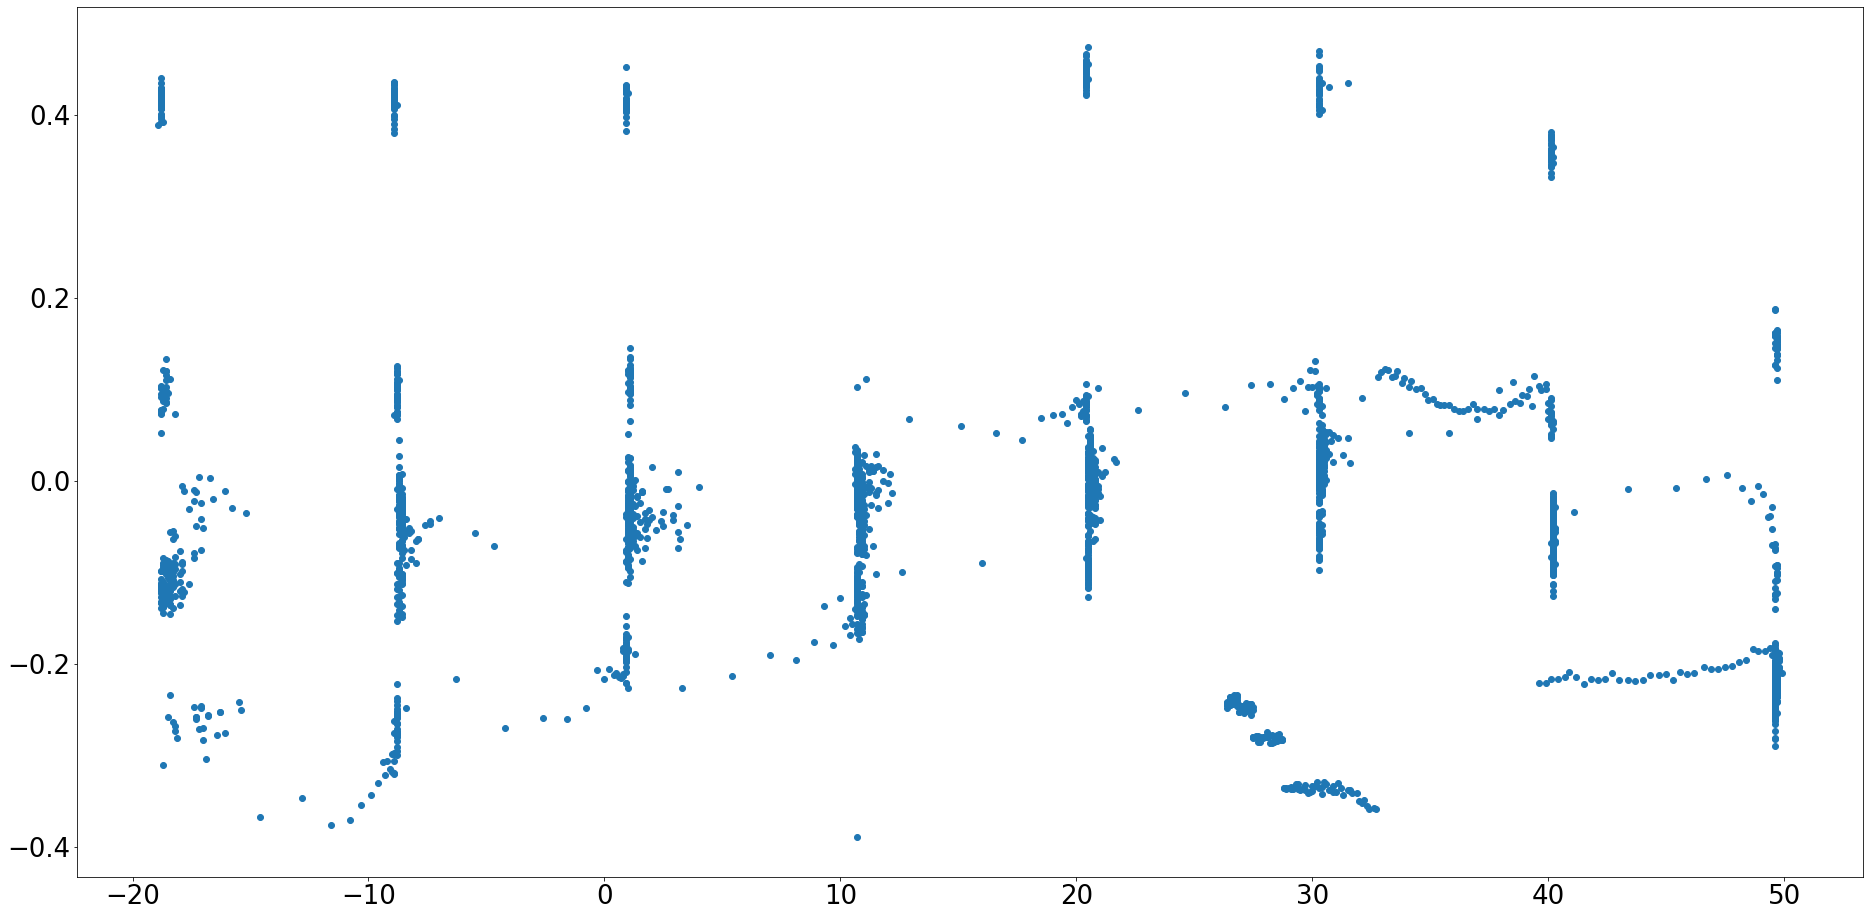

In [14]:
# Plot error vs temperature
fig,ax = plt.subplots(figsize=(32,16))
fig.set_facecolor('w')
plt.scatter(analyser.dfs[0]["Temperature"],analyser.dfs[0]["Error"])
plt.show()